<a href="https://colab.research.google.com/github/muffin-head/essex_work/blob/main/essex_dissertation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import requests
import pandas as pd
import json
import numpy as np
def fetch_expanded_clinical_data(project):
    """
    Fetch expanded clinical and diagnosis data for a specific project from the GDC.

    Parameters:
    - project: The project ID (e.g., "TCGA-BRCA").

    Returns:
    A pandas DataFrame with the expanded clinical data.
    """
    # Endpoint for searching cases in GDC
    cases_endpt = "https://api.gdc.cancer.gov/cases"

    # Updated to include additional fields
    fields = [
        "case_id",
        "demographic.gender",

        "demographic.race",
        "demographic.ethnicity",
        "diagnoses.primary_diagnosis",
        "diagnoses.days_to_diagnosis",
        "diagnoses.tissue_or_organ_of_origin",
        "diagnoses.treatments.treatment_type",
        "diagnoses.treatments.outcome",
        "diagnoses.morphology",
        "diagnoses.year_of_diagnosis",
        "diagnoses.ajcc_pathologic_stage",
        "diagnoses.age_at_diagnosis",
        "diagnoses.prior_malignancy",

        "diagnoses.days_to_last_follow_up",# Added
        "project.disease_type",  # Added
        "project.primary_site",  # Added
        "samples.longest_dimension",  # Added
        # Note: "cancer.type" and "Subtype_Selected" might not directly correspond to GDC fields.
        # You may need metadata annotations or additional logic to derive these values.
    ]
    filters = {
        "op": "in",
        "content": {
            "field": "project.project_id",
            "value": [project]
        }
    }
    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(fields),
        "format": "JSON",
        "size": "3000"  # Adjust size based on expected number of cases
    }

    response = requests.get(cases_endpt, params=params)
    expanded_clinical_details = []

    if response.status_code == 200:
        data = response.json()["data"]["hits"]
        for case in data:
            demographics = case.get("demographic", {})
            samples = case.get("samples", [{}])[0]
            for diagnosis in case.get("diagnoses", []):
                treatments = diagnosis.get("treatments", [])
                for treatment in treatments:
                    expanded_clinical_details.append({
                        "Case ID": case["case_id"],
                        "Gender": demographics.get("gender"),
                        "Race": demographics.get("race"),
                        "Ethnicity": demographics.get("ethnicity"),


                        "Primary Diagnosis": diagnosis.get("primary_diagnosis"),
                        "prior_malignancy": diagnosis.get("prior_malignancy"),


                        "days_to_last_follow_up": diagnosis.get("days_to_last_follow_up"),
                        "age_at_diagnosis": diagnosis.get("age_at_diagnosis"),
                        "ajcc_pathologic_stage": diagnosis.get("ajcc_pathologic_stage"),
                        #"days_to_diagnosis": diagnosis.get("days_to_diagnosis"),
                        "Treatment Type": treatment.get("treatment_type"),
                        #"Treatment outcome": treatment.get("drug_category"),
                        "Morphology": diagnosis.get("morphology"),
                        "Year of Diagnosis": diagnosis.get("year_of_diagnosis"),
                        "Tissue or Organ of Origin": diagnosis.get("tissue_or_organ_of_origin"),
                        #"Primary Site": case.get("project", {}).get("primary_site"),
                        "Longest Dimension": samples.get("longest_dimension"),
                        # "Cancer Type" and "Subtype Selected" handling depends on your specific data annotations or additional fields
                    })

        return pd.DataFrame(expanded_clinical_details)
    else:
        print("Failed to query GDC API.")
        return pd.DataFrame()

# Example usage
project_id = "TCGA-LUAD"  # Example: Lung Adenocarcinoma
expanded_clinical_df = fetch_expanded_clinical_data(project_id)
expanded_clinical_df['age'] = np.where(pd.notnull(expanded_clinical_df['age_at_diagnosis']),(expanded_clinical_df['age_at_diagnosis'] / 365.25).round(),np.nan)
expanded_clinical_df.drop(['age_at_diagnosis'],axis=1)

,Case ID,Gender,Race,Ethnicity,Primary Diagnosis,prior_malignancy,days_to_last_follow_up,ajcc_pathologic_stage,Treatment Type,Morphology,Year of Diagnosis,Tissue or Organ of Origin,Longest Dimension,age
0,ac0d7a82-82cb-4aec-b859-e37375f3de8b,female,not reported,not reported,Acinar cell carcinoma,no,657.0,Stage IIIA,"Radiation Therapy, NOS",8550/3,2012.0,"Lower lobe, lung",1.9,79.0
1,ac0d7a82-82cb-4aec-b859-e37375f3de8b,female,not reported,not reported,Acinar cell carcinoma,no,657.0,Stage IIIA,"Pharmaceutical Therapy, NOS",8550/3,2012.0,"Lower lobe, lung",1.9,79.0
2,ae39e358-08d7-4367-ae68-82b469e791e4,male,white,not hispanic or latino,"Adenocarcinoma, NOS",no,40.0,Stage IIIA,"Pharmaceutical Therapy, NOS",8140/3,2010.0,"Lower lobe, lung",1.6,59.0
3,ae39e358-08d7-4367-ae68-82b469e791e4,male,white,not hispanic or latino,"Adenocarcinoma, NOS",no,40.0,Stage IIIA,"Radiation Therapy, NOS",8140/3,2010.0,"Lower lobe, lung",1.6,59.0
4,aea68827-dc0f-484d-a00d-06deeaa4b3ce,male,not reported,not reported,Adenocarcinoma with mixed subtypes,no,730.0,Stage IB,"Pharmaceutical Therapy, NOS",8255/3,2008.0,"Lower lobe, lung",1.1,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,fcfe0b53-dfc1-42fa-9efc-2b2ff259297e,male,white,not hispanic or latino,"Micropapillary carcinoma, NOS",no,564.0,Stage IB,"Radiation Therapy, NOS",8265/3,2011.0,"Upper lobe, lung",1.1,65.0
1040,fd5c44ef-ea50-4fba-9e8d-e371cf34ebdb,female,white,not reported,Adenocarcinoma with mixed subtypes,no,NaN,Stage IIIA,"Pharmaceutical Therapy, NOS",8255/3,2000.0,"Upper lobe, lung",0.7,53.0
1041,fd5c44ef-ea50-4fba-9e8d-e371cf34ebdb,female,white,not reported,Adenocarcinoma with mixed subtypes,no,NaN,Stage IIIA,"Radiation Therapy, NOS",8255/3,2000.0,"Upper lobe, lung",0.7,53.0
1042,ff07ea4b-4e50-410d-99d6-96a351dad7b1,male,black or african american,not hispanic or latino,"Adenocarcinoma, NOS",no,824.0,Stage IA,"Radiation Therapy, NOS",8140/3,2011.0,"Upper lobe, lung",NaN,61.0


<ipython-input-27-5492a8d0de22>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_27, x='index', y='prior_malignancy', inner='box', palette='Dark2')


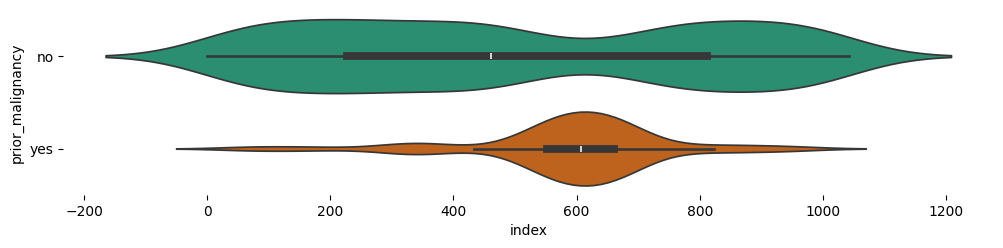

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_27['prior_malignancy'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_27, x='index', y='prior_malignancy', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<ipython-input-28-54d873b6e16f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_df_25, x='index', y='Race', inner='box', palette='Dark2')


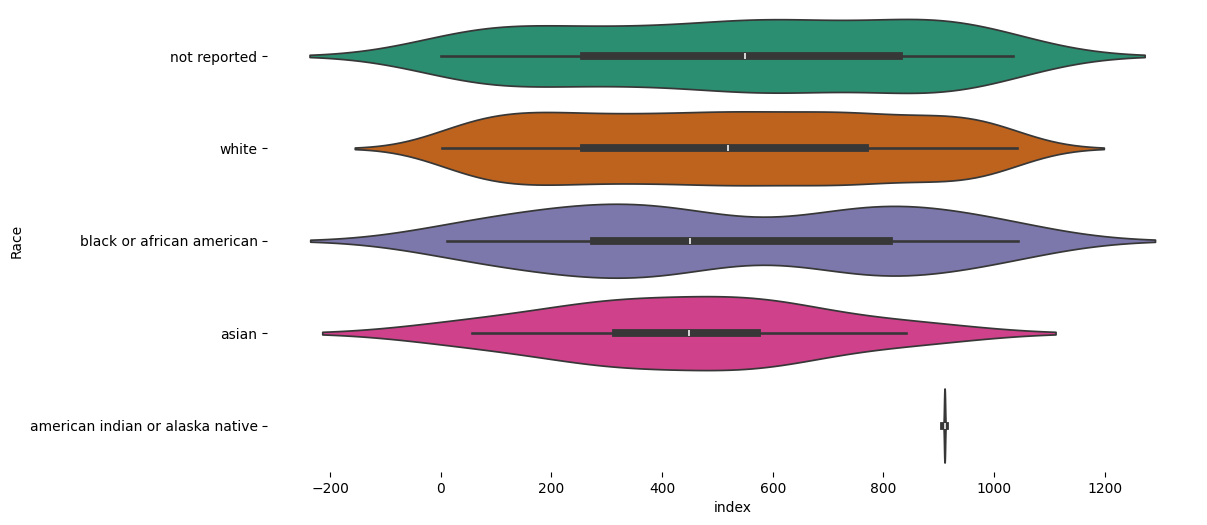

In [28]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['Race'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='index', y='Race', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

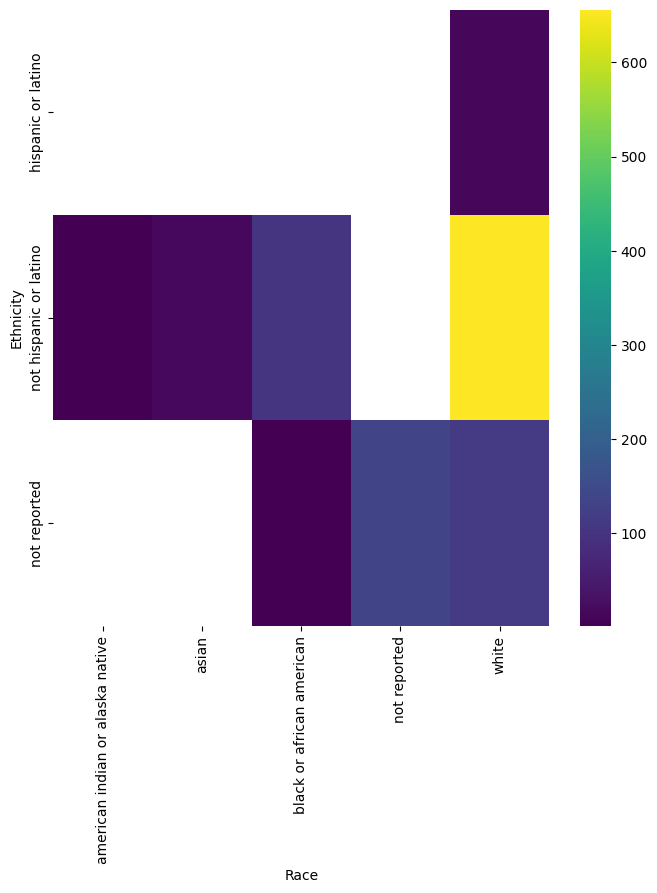

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Ethnicity'].value_counts()
    for x_label, grp in _df_21.groupby('Race')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Race')
_ = plt.ylabel('Ethnicity')

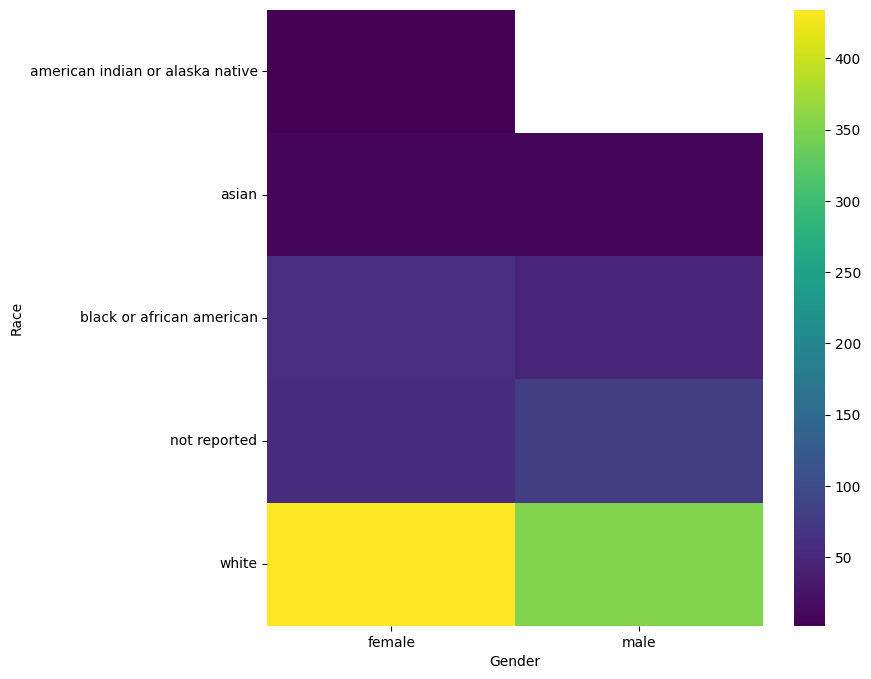

In [30]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Race'].value_counts()
    for x_label, grp in _df_20.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('Race')

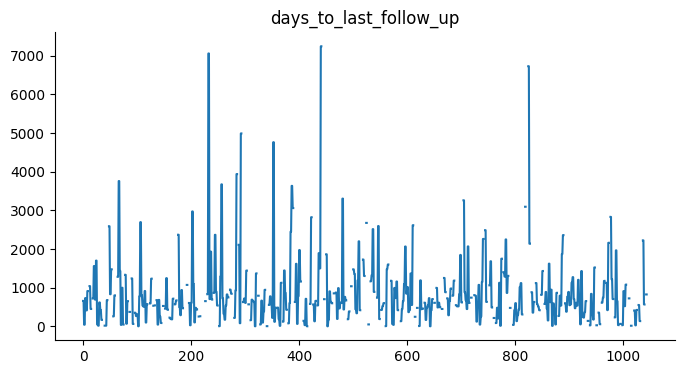

In [31]:
from matplotlib import pyplot as plt
_df_17['days_to_last_follow_up'].plot(kind='line', figsize=(8, 4), title='days_to_last_follow_up')
plt.gca().spines[['top', 'right']].set_visible(False)

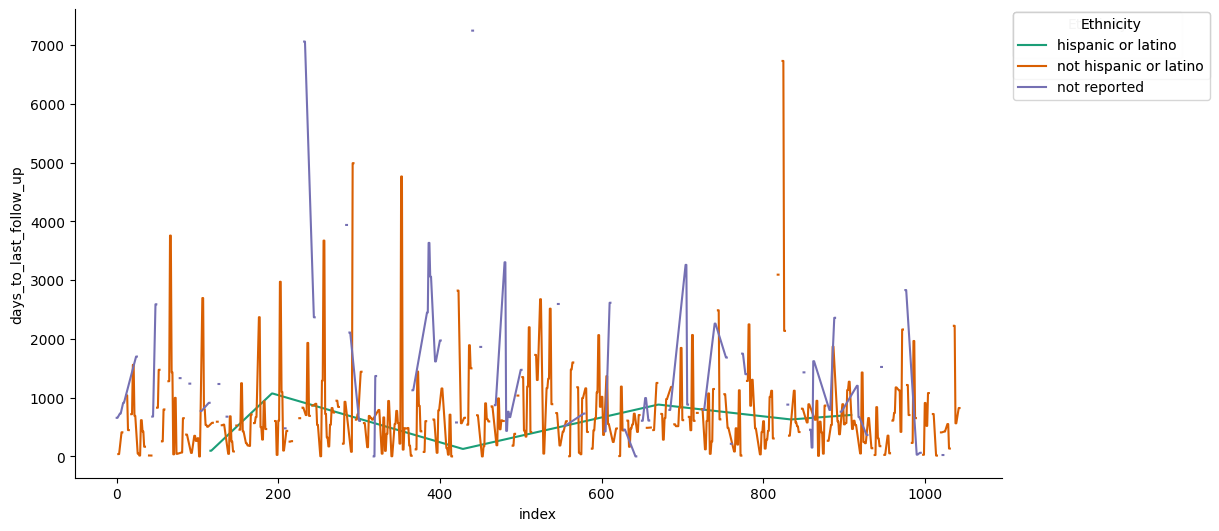

In [32]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['days_to_last_follow_up']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Ethnicity')):
  _plot_series(series, series_name, i)
  fig.legend(title='Ethnicity', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('days_to_last_follow_up')

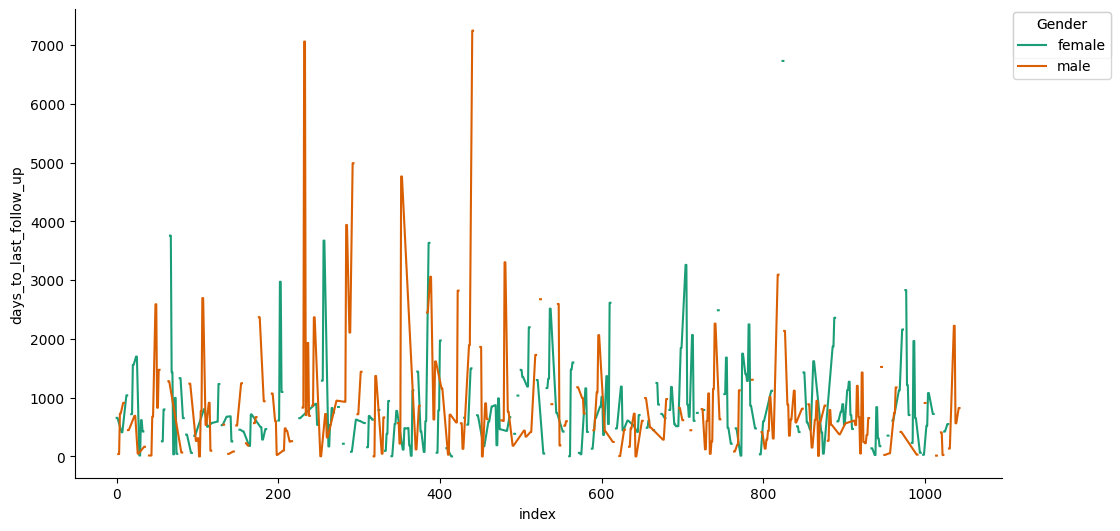

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['days_to_last_follow_up']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='Gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('days_to_last_follow_up')

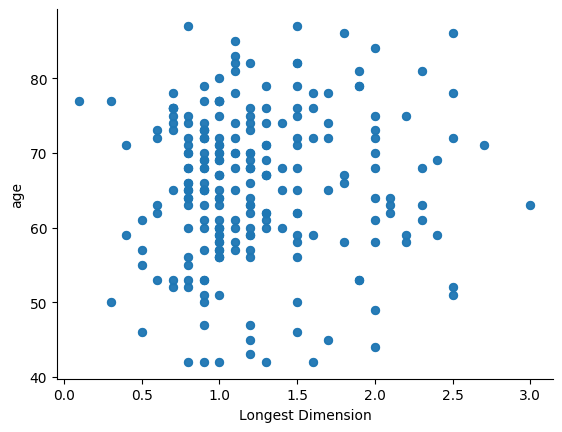

In [34]:
from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='Longest Dimension', y='age', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

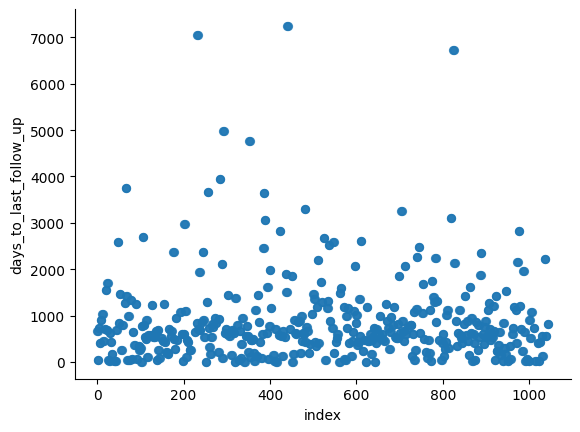

In [35]:
from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='index', y='days_to_last_follow_up', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

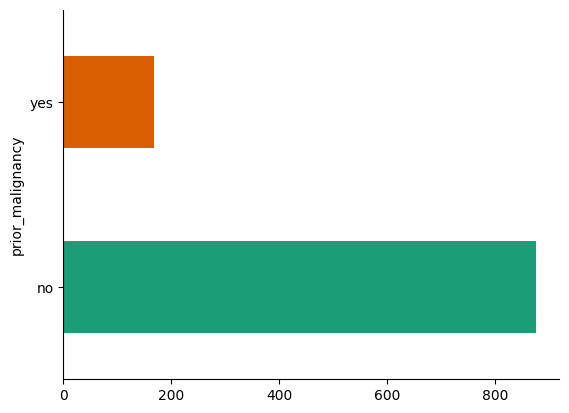

In [36]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('prior_malignancy').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

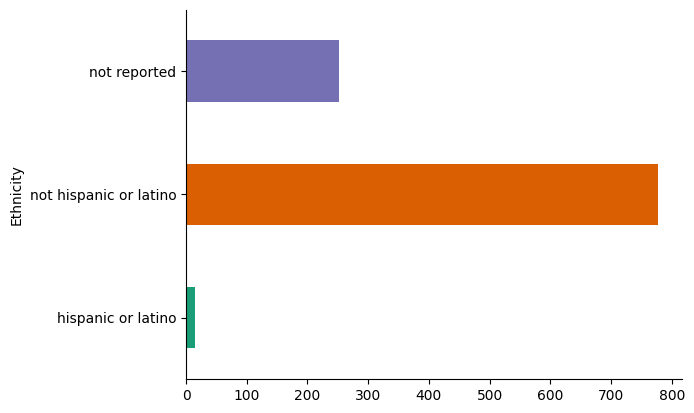

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_6.groupby('Ethnicity').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

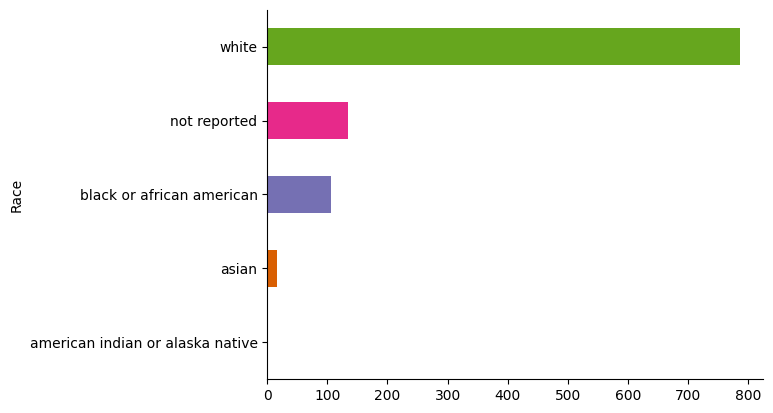

In [38]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('Race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

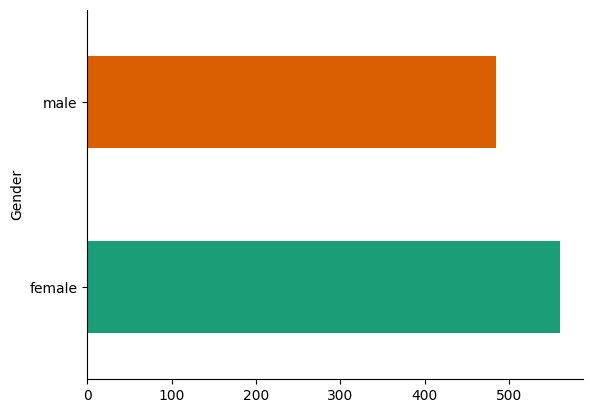

In [39]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

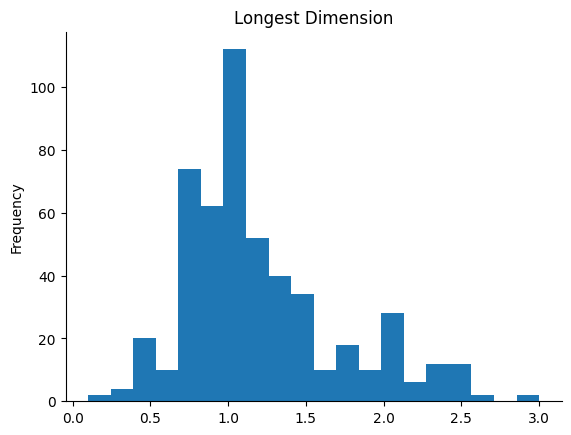

In [40]:
from matplotlib import pyplot as plt
_df_3['Longest Dimension'].plot(kind='hist', bins=20, title='Longest Dimension')
plt.gca().spines[['top', 'right',]].set_visible(False)

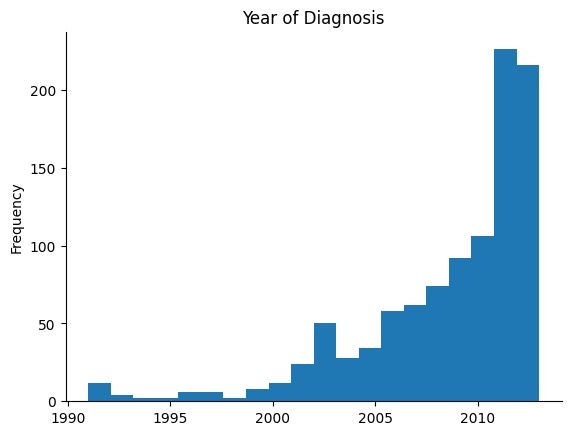

In [41]:
from matplotlib import pyplot as plt
_df_2['Year of Diagnosis'].plot(kind='hist', bins=20, title='Year of Diagnosis')
plt.gca().spines[['top', 'right',]].set_visible(False)

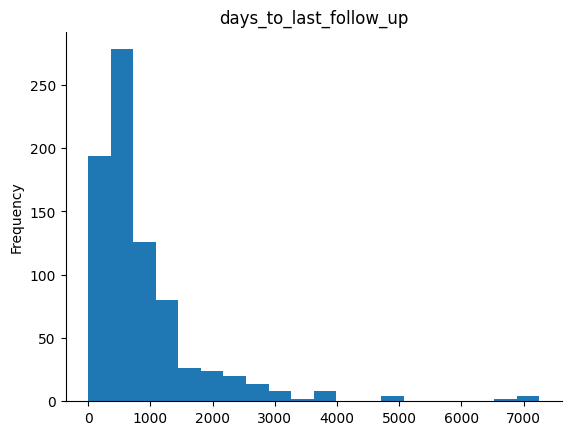

In [42]:
from matplotlib import pyplot as plt
_df_1['days_to_last_follow_up'].plot(kind='hist', bins=20, title='days_to_last_follow_up')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [43]:
expanded_clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Case ID                    1044 non-null   object 
 1   Gender                     1044 non-null   object 
 2   Race                       1044 non-null   object 
 3   Ethnicity                  1044 non-null   object 
 4   Primary Diagnosis          1044 non-null   object 
 5   prior_malignancy           1044 non-null   object 
 6   days_to_last_follow_up     790 non-null    float64
 7   age_at_diagnosis           982 non-null    float64
 8   ajcc_pathologic_stage      1028 non-null   object 
 9   Treatment Type             1044 non-null   object 
 10  Morphology                 1044 non-null   object 
 11  Year of Diagnosis          1024 non-null   float64
 12  Tissue or Organ of Origin  1044 non-null   object 
 13  Longest Dimension          510 non-null    float

In [46]:
expanded_clinical_df['Race'].value_counts()

white                               786
not reported                        134
black or african american           106
asian                                16
american indian or alaska native      2
Name: Race, dtype: int64

In [25]:
expanded_clinical_df.to_csv('dataset.csv')

In [49]:
expanded_clinical_df['Gender_encoded'] = expanded_clinical_df['Gender'].map({'male': 1, 'female': 0})
expanded_clinical_df.drop(columns=['Gender'],inplace=True)

In [ ]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['Race'], prefix='Race')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['Race'], inplace=True)


In [ ]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['Ethnicity'], prefix='Ethnicity')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['Ethnicity'], inplace=True)



In [ ]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['Primary Diagnosis'], prefix='Primary Diagnosis')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['Primary Diagnosis'], inplace=True)



In [ ]:
expanded_clinical_df['age'] = np.where(pd.notnull(expanded_clinical_df['age_at_diagnosis']),
                                       (expanded_clinical_df['age_at_diagnosis'] / 365.25).round(),
                                       np.nan)

# Optional: if you want to convert ages to integers and keep NaNs as is (pandas >= 0.24)
expanded_clinical_df['age'] = expanded_clinical_df['age'].astype("Int64")
expanded_clinical_df.drop(columns=['age_at_diagnosis'], inplace=True)


In [57]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['ajcc_pathologic_stage'], prefix='ajcc_pathologic_stage')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['ajcc_pathologic_stage'], inplace=True)



In [59]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['Tissue or Organ of Origin'], prefix='Tissue or Organ of Origin')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['Tissue or Organ of Origin','Case ID'], inplace=True)



In [63]:


# Applying one-hot encoding to the 'Race' column
race_one_hot = pd.get_dummies(expanded_clinical_df['Treatment Type'], prefix='Treatment Type')

# Joining the one-hot encoded columns back to the original DataFrame
expanded_clinical_df = expanded_clinical_df.join(race_one_hot)

# Removing the original 'Race' column from the DataFrame
expanded_clinical_df.drop(columns=['Treatment Type','Year of Diagnosis'], inplace=True)



In [64]:
expanded_clinical_df

,prior_malignancy,days_to_last_follow_up,Morphology,Longest Dimension,Gender_encoded,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,...,ajcc_pathologic_stage_Stage IIIB,ajcc_pathologic_stage_Stage IV,"Tissue or Organ of Origin_Lower lobe, lung","Tissue or Organ of Origin_Lung, NOS",Tissue or Organ of Origin_Main bronchus,"Tissue or Organ of Origin_Middle lobe, lung",Tissue or Organ of Origin_Overlapping lesion of lung,"Tissue or Organ of Origin_Upper lobe, lung","Treatment Type_Pharmaceutical Therapy, NOS","Treatment Type_Radiation Therapy, NOS"
0,no,657.0,8550/3,1.9,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,no,657.0,8550/3,1.9,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
2,no,40.0,8140/3,1.6,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0
3,no,40.0,8140/3,1.6,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
4,no,730.0,8255/3,1.1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,no,564.0,8265/3,1.1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1040,no,NaN,8255/3,0.7,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
1041,no,NaN,8255/3,0.7,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1042,no,824.0,8140/3,NaN,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1


In [85]:
expanded_clinical_df['days_to_last_follow_up'].value_counts()

0.0       10
791.0      8
610.0      6
603.0      6
3.0        6
          ..
481.0      2
116.0      2
4765.0     2
218.0      2
564.0      2
Name: days_to_last_follow_up, Length: 335, dtype: int64

In [87]:
expanded_clinical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 44 columns):
 #   Column                                                         Non-Null Count  Dtype  
---  ------                                                         --------------  -----  
 0   prior_malignancy                                               1044 non-null   int64  
 1   days_to_last_follow_up                                         1044 non-null   float64
 2   Longest Dimension                                              1044 non-null   float64
 3   Gender_encoded                                                 1044 non-null   int64  
 4   Race_american indian or alaska native                          1044 non-null   uint8  
 5   Race_asian                                                     1044 non-null   uint8  
 6   Race_black or african american                                 1044 non-null   uint8  
 7   Race_not reported                                           

In [ ]:
# Assuming 'target' is the name of your target column in the DataFrame 'expanded_clinical_df'
expanded_clinical_df['prior_malignancy'] = expanded_clinical_df['prior_malignancy'].map({'yes': 1, 'no': 0})

# Check the first few rows to verify the encoding

In [ ]:
!pip install category_encoders
from category_encoders import TargetEncoder

X = expanded_clinical_df[['Morphology']]
y = expanded_clinical_df['prior_malignancy']  # Corrected column name
target_encoder = TargetEncoder()
expanded_clinical_df['Morphology_encoded'] = target_encoder.fit_transform(X, y)
expanded_clinical_df.drop(columns=['Morphology'], inplace=True)


In [82]:
from sklearn.preprocessing import StandardScaler

expanded_clinical_df['Longest Dimension'].fillna(expanded_clinical_df['Longest Dimension'].median(), inplace=True)

longest_dimension = expanded_clinical_df[['Longest Dimension']].values

scaler = StandardScaler()
expanded_clinical_df['Longest Dimension'] = scaler.fit_transform(longest_dimension)


,prior_malignancy,days_to_last_follow_up,Longest Dimension,Gender_encoded,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,Ethnicity_hispanic or latino,...,"Tissue or Organ of Origin_Lower lobe, lung","Tissue or Organ of Origin_Lung, NOS",Tissue or Organ of Origin_Main bronchus,"Tissue or Organ of Origin_Middle lobe, lung",Tissue or Organ of Origin_Overlapping lesion of lung,"Tissue or Organ of Origin_Upper lobe, lung","Treatment Type_Pharmaceutical Therapy, NOS","Treatment Type_Radiation Therapy, NOS",prior_malignancy_encoded,Morphology_encoded
0,0,657.0,2.088095,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0.096732
1,0,657.0,2.088095,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0.096732
2,0,40.0,1.249214,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0.176101
3,0,40.0,1.249214,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0.176101
4,0,730.0,-0.148920,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0,564.0,-0.148920,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0.129087
1040,0,NaN,-1.267427,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0.166667
1041,0,NaN,-1.267427,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0.166667
1042,0,824.0,-0.148920,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0.176101


In [ ]:
from sklearn.preprocessing import StandardScaler

expanded_clinical_df['days_to_last_follow_up'].fillna(expanded_clinical_df['days_to_last_follow_up'].median(), inplace=True)

days_to_last_follow_up = expanded_clinical_df[['days_to_last_follow_up']].values

scaler = StandardScaler()
expanded_clinical_df['days_to_last_follow_up'] = scaler.fit_transform(days_to_last_follow_up)



In [88]:
expanded_clinical_df['age'].fillna(expanded_clinical_df['age'].median(), inplace=True)

In [89]:
expanded_clinical_df

,prior_malignancy,days_to_last_follow_up,Longest Dimension,Gender_encoded,Race_american indian or alaska native,Race_asian,Race_black or african american,Race_not reported,Race_white,Ethnicity_hispanic or latino,...,"Tissue or Organ of Origin_Lower lobe, lung","Tissue or Organ of Origin_Lung, NOS",Tissue or Organ of Origin_Main bronchus,"Tissue or Organ of Origin_Middle lobe, lung",Tissue or Organ of Origin_Overlapping lesion of lung,"Tissue or Organ of Origin_Upper lobe, lung","Treatment Type_Pharmaceutical Therapy, NOS","Treatment Type_Radiation Therapy, NOS",prior_malignancy_encoded,Morphology_encoded
0,0,-0.184305,2.088095,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0.096732
1,0,-0.184305,2.088095,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0.096732
2,0,-0.933523,1.249214,1,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0.176101
3,0,-0.933523,1.249214,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0.176101
4,0,-0.095662,-0.148920,1,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0.166667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,0,-0.297234,-0.148920,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0.129087
1040,0,-0.224377,-1.267427,0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,0,0.166667
1041,0,-0.224377,-1.267427,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0.166667
1042,0,0.018482,-0.148920,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0.176101


In [91]:
expanded_clinical_df.to_csv('preprocessing.csv')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Preparing the data
X = expanded_clinical_df.drop(['prior_malignancy', 'prior_malignancy_encoded'], axis=1)
y = expanded_clinical_df['prior_malignancy'].astype(int)
# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Addressing the imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Building and training the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predicting on the test set
y_pred = model.predict(X_test)

# Calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)
accuracy


In [97]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = expanded_clinical_df[expanded_clinical_df.prior_malignancy == 0]
df_minority = expanded_clinical_df[expanded_clinical_df.prior_malignancy == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])



In [99]:
X = df_upsampled.drop(['prior_malignancy', 'prior_malignancy_encoded'], axis=1)
y = df_upsampled['prior_malignancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
# Using Logistic Regression as an example
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
y_pred = model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy Score: {accuracy:.4f}')

# Generate a classification report to see the model's performance across all classes
print(classification_report(y_test, y_pred))

Accuracy Score: 0.6325
              precision    recall  f1-score   support

           0       0.67      0.58      0.62       182
           1       0.60      0.69      0.64       169

    accuracy                           0.63       351
   macro avg       0.64      0.63      0.63       351
weighted avg       0.64      0.63      0.63       351

